classy imported from: 
 /home/quantumer/class_wzdr_corrected_ICs/python/build/lib.linux-x86_64-3.10/classy.cpython-310-x86_64-linux-gnu.so
gdm exists
Starting CLASS

Omega_m = 0.317910
CLASS is done!

9.891937997081783
Computing the perturbations



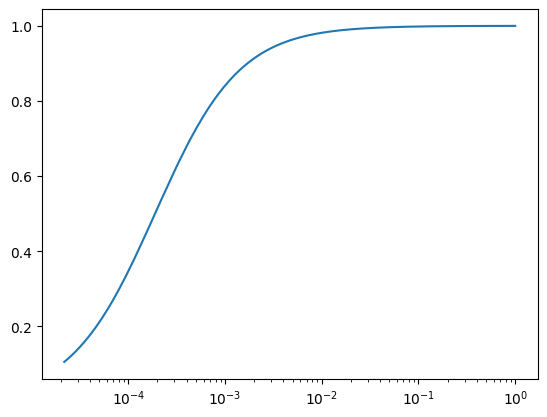

In [4]:
# This file outputs the energy density function for the WZDR model and play some plots with it.

import sys
sys.path.insert(0, "/home/quantumer/class_wzdr_corrected_ICs/python/build/lib.linux-x86_64-3.10")
import subprocess

import classy
print("classy imported from: \n",classy.__file__)

# import necessary modules
# uncomment to get plots displayed in notebook
import numpy as np
from classy import Class
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import os
import math
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt

basedir = os.path.abspath('./')
gdmdir = os.path.join(basedir,'gdm_files')

gdm_exists = os.path.exists('./gdm_files')

if gdm_exists :
     print('gdm exists')
#    subprocess.run(["rm","-r","gdm_files"])
#    subprocess.run(["mkdir","gdm_files"])
else :
    subprocess.run(["mkdir","gdm_files"])

#############################################
#
# Cosmological parameters:
z_max_pk = 46000       # highest redshift involved
k_per_decade =250     # number of k values, controls final resolution
k_min_tau0 = 0.002       # this value controls the minimum k value in the figure (it is k_min * tau0)
P_k_max_inv_Mpc =1   # this value is directly the maximum k value in the figure in Mpc
tau_num_early = 2000   # number of conformal time values before recombination, controls final resolution
tau_num_late = 1500     # number of conformal time values after recombination, controls final resolution
tau_ini = 10.          # first value of conformal time in Mpc
tau_label_Hubble = 20. # value of time at which we want to place the label on Hubble crossing
tau_label_ks = 40.     # value of time at which we want to place the label on sound horizon crossing
tau_label_kd = 230.    # value of time at which we want to place the label on damping scale crossing
h=0.67


common_settings = {# which output? transfer functions only
                   'output':'mTk,vTk',
                   # LambdaCDM parameters
                   'h':0.67,
                   'omega_b':0.02233,
                   'omega_cdm':0.00001,
                   'omega_idm_wzdr':0.12037, 
                   'A_s':2.215e-9,
                   'n_s':0.9652,
                   'tau_reio':0.0540,
                   'N_wzdr': 0.01,
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
                   'YHe':0.246,
                   # other output and precision parameters
                   'z_max_pk':z_max_pk,
                   # to get a larger z_max in recfast, 
                   # we must increase both recfast_z_initial 
                   # and the number of sampled values recfast_Nz0
                   # (in order to keep the same stepzize asd in the default: Delta z = 0.5)
                  # 'recfast_Nz0':z_max_pk*2.,
                  # 'recfast_z_initial':z_max_pk+1.,
                   #'k_step_sub':'0.01',
                   'k_per_decade_for_pk':k_per_decade,
                   'k_per_decade_for_bao':k_per_decade,
                   'k_min_tau0':k_min_tau0, # this value controls the minimum k value in the figure
                   'perturbations_sampling_stepsize':'0.05',
                   'P_k_max_1/Mpc':P_k_max_inv_Mpc,
                   'compute damping scale':'yes', # needed to output and plot Silk damping scale
                   'gauge':'synchronous',
                    'log10_zt_wzdr':4,
                    #'log10_a_idm_wzdr':-1.44,
                    'Gamma_0_wzdr':1.631329e-07,
                    'rg_wzdr':1.14285714286,
                    'qsize_wzdr':10000,
                    'qmax_wzdr':200.,
                    'use_wzdr_PSD':'yes'}


###############
#
# call CLASS
#
###############
print("Starting CLASS\n")

M_pre = Class()
M_pre.set(common_settings)
M_pre.compute()

print("CLASS is done!\n")

background = M_pre.get_background() # load background table                                                                                                                           
#print background.viewkeys()  

background_tau = background['conf. time [Mpc]'] # read conformal times in background table       
background_z = background['z'] # read redshift
background_tau_at_z = interp1d(background_z,background_tau)

tau_ini = background_tau_at_z(z_max_pk)
print(tau_ini)

times = M_pre.get_current_derived_parameters(['tau_rec','conformal_age'])
tau_rec=times['tau_rec']
tau_0 = times['conformal_age']
tau1 = np.logspace(math.log10(tau_ini),math.log10(5*tau_rec),tau_num_early)
tau2 = np.logspace(math.log10(5*tau_rec),math.log10(tau_0),tau_num_late)[1:]
tau2[-1]=tau_0
tau2[-1] *= 0.999999 # this tiny shift avoids interpolation errors
tau= np.concatenate((tau1,tau2))
tau_num = len(tau)


#background = M_pre.get_background() # load background table
#print background.viewkeys()

#background_tau = background['conf. time [Mpc]'] # read conformal times in background table
background_z = background['z'] # read redshift
background_aH = background['H [1/Mpc]']/(1.+background['z'])

background_rho_cdm = background['(.)rho_cdm'] # read rho cdm in background table
background_rho_nu = background['(.)rho_ur'] # read rho nu in background table
background_rho_wzdr = background['(.)rho_wzdr']
background_rho_idm_wzdr = background['(.)rho_idm_wzdr']

cs_2_wzdr = background['cs2_wzdr']
w_wzdr = background['w_wzdr']

background_z_at_tau = interp1d(background_tau,background_z)
a_tau = 1/(1+background_z_at_tau(tau))

background_aH_at_a = interp1d(1/(background_z+1),background_aH)
background_aH_at_tau = interp1d(background_tau,background_aH)
background_a_at_tau = interp1d(background_tau,1/(background_z+1))

background_rho_cdm_tau = interp1d(background_tau,background_rho_cdm)
background_rho_nu_tau = interp1d(background_tau,background_rho_nu)
background_rho_wzdr_tau = interp1d(background_tau,background_rho_wzdr)
background_rho_idm_wzdr_tau = interp1d(background_tau,background_rho_idm_wzdr)
cs_2_wzdr_tau = interp1d(background_tau,cs_2_wzdr)
w_wzdr_tau = interp1d(background_tau,w_wzdr)

w_T_st = 1/3*background_rho_nu/(background_rho_cdm+background_rho_nu)
w_T_CF = w_wzdr*background_rho_wzdr/(background_rho_wzdr+background_rho_idm_wzdr)
w_T_general = (w_T_st*(background_rho_cdm+background_rho_nu)+w_T_CF*(background_rho_wzdr+background_rho_idm_wzdr))/(background_rho_cdm+background_rho_nu+background_rho_wzdr+background_rho_idm_wzdr)

w_T_at_a_interp = interp1d(1/(1+background_z),w_T_general)
w_T_at_a_list = w_T_at_a_interp(a_tau)

w_T_at_a_prime_interp = UnivariateSpline(1/(1+background_z),w_T_general,s=0).derivative()
#w_T_at_a_prime = UnivariateSpline(a_tau,w_T_at_a_list,s=0)
w_T_at_a_prime_list = w_T_at_a_prime_interp(a_tau)

ones = np.ones(len(background_z))
ca2_list = w_T_at_a_interp(1/(1+background_z)) - 1./3.*1/(1+background_z)*w_T_at_a_prime_interp(1/(1+background_z))/(ones+w_T_at_a_interp(1/(1+background_z)) )
ca2_a = interp1d(1/(1+background_z),ca2_list)

ones = np.ones(len(a_tau))
ca2_list = w_T_at_a_list - 1./3.*a_tau*w_T_at_a_prime_list/(1+w_T_at_a_list)
ca2_tau = interp1d(tau,ca2_list)

w_T_tau = interp1d(background_tau,w_T_general)

one_time = M_pre.get_transfer(background_z_at_tau(tau[0]))
k = one_time['k (h/Mpc)']
k_num = len(k)

print("Computing the perturbations\n")

#sigma_d = np.zeros((tau_num,k_num))
#delta_d = np.zeros((tau_num,k_num))
#theta_d = np.zeros((tau_num,k_num))
#cs2_d = np.zeros((tau_num,k_num))
#c2eff_d = np.zeros((tau_num,k_num))
#Dc2_d = np.zeros((tau_num,k_num))
#cs2_d_st = np.zeros((tau_num,k_num))
delta = np.zeros((tau_num,k_num))

for i in range(tau_num):
    one_time = M_pre.get_transfer(background_z_at_tau(tau[i])) # transfer functions at each time tau 
    
    delta[i,:] = (one_time['d_wzdr'][:]*background_rho_wzdr_tau(tau[i])+one_time['d_idm_wzdr']*background_rho_idm_wzdr_tau(tau[i]))/(one_time['d_ur'][:]*background_rho_nu_tau(tau[i])+one_time['d_cdm'][:]*background_rho_cdm_tau(tau[i])+one_time['d_wzdr'][:]*background_rho_wzdr_tau(tau[i])+one_time['d_idm_wzdr']*background_rho_idm_wzdr_tau(tau[i]))
    
#    delta_d[i,:] = (one_time['d_ur'][:]*background_rho_nu_tau(tau[i]) + background_rho_cdm_tau(tau[i])*one_time['d_cdm'][:] + background_rho_wzdr_tau(tau[i])*one_time['d_wzdr'][:]+background_rho_idm_wzdr_tau(tau[i])*one_time['d_idm_wzdr'])/(background_rho_cdm_tau(tau[i])+background_rho_nu_tau(tau[i])+background_rho_wzdr_tau(tau[i])+background_rho_idm_wzdr_tau(tau[i]))
    
#     delta_T_std[i]= (background_rho_cdm_at_a_std(a_std[i])*delta_cdm[i]+background_rho_nu_at_a_std(a_std[i])*delta_nu[i])\
#     /(background_rho_cdm_at_a_std(a_std[i])+background_rho_nu_at_a_std(a_std[i]))
#     theta_T_std[i] = ((1+1/3)*background_rho_nu_at_a_std(a_std[i])*theta_nu[i])\
#                     /((background_rho_cdm_at_a_std(a_std[i])+background_rho_nu_at_a_std(a_std[i])*(1.+1./3.)))
    
#    theta_d[i,:] = ((1+1/3)*one_time['t_ur'][:]*background_rho_nu_tau(tau[i])+(1+w_wzdr_tau(tau[i]))*one_time['t_wzdr'][:]*background_rho_nu_tau(tau[i])+background_rho_idm_wzdr_tau(tau[i])*one_time['t_idm_wzdr'])\
#    /(background_rho_cdm_tau(tau[i])+(1+1/3)*background_rho_nu_tau(tau[i])+(1+w_wzdr_tau(tau[i]))*background_rho_wzdr_tau(tau[i])+background_rho_idm_wzdr_tau(tau[i]))
    
#    cs2_d_st[i,:] = (1./3.*one_time['d_ur'][:]*background_rho_nu_tau(tau[i]))\
#            /(background_rho_cdm_tau(tau[i])*one_time['d_cdm'][:]+background_rho_nu_tau(tau[i])*one_time['d_ur'][:])
    
#    cs2_d[i,:] = cs2_d_st[i,:]*(one_time['d_ur'][:]*background_rho_nu_tau(tau[i])+background_rho_cdm_tau(tau[i])*one_time['d_cdm'][:])\
#    /(one_time['d_ur'][:]*background_rho_nu_tau(tau[i])+background_rho_cdm_tau(tau[i])*one_time['d_cdm'][:]+one_time['d_wzdr'][:]*background_rho_wzdr_tau(tau[i])+one_time['d_idm_wzdr'][:]*background_rho_idm_wzdr_tau(tau[i]))\
#    +cs_2_wzdr_tau(tau[i])*(one_time['d_wzdr'][:]*background_rho_wzdr_tau(tau[i]))/(one_time['d_ur'][:]*background_rho_nu_tau(tau[i])+background_rho_cdm_tau(tau[i])*one_time['d_cdm'][:]+one_time['d_wzdr'][:]*background_rho_wzdr_tau(tau[i])+one_time['d_idm_wzdr'][:]*background_rho_idm_wzdr_tau(tau[i]))

#    c2eff_d[i,:] = ((k*h)**2*cs2_d[i,:]*delta_d[i,:]+3*background_aH_at_tau(tau[i])*ca2_tau(tau[i])*(1+w_T_tau(tau[i]))*theta_d[i,:])\
#        /((k*h)**2*delta_d[i,:]+3*background_aH_at_tau(tau[i])*(1+w_T_tau(tau[i]))*theta_d[i,:])

#    Dc2_d[i,:] = c2eff_d[i,:]-ca2_tau(tau[i])

#    sigma_d[i,:] = ((1+1/3)*background_rho_nu_tau(tau[i])*one_time['shear_ur'])\
#             /(background_rho_cdm_tau(tau[i])+(1+1/3)*background_rho_nu_tau(tau[i]))
    
    
    
#print("Saving the files\n")

#np.savetxt(os.path.join(gdmdir,'k_values.dat'),k)
#np.savetxt(os.path.join(gdmdir,'cs2_T.dat'), c2eff_d.ravel())
#np.savetxt(os.path.join(gdmdir,'sigma_T.dat'),sigma_d.ravel())
#np.savetxt(os.path.join(gdmdir,'w_T.dat'), np.column_stack([a_tau,w_T_at_a_list,w_T_at_a_prime_list]))

# These codes are plotting the delta[k] v.s. a_tau. These codes choose special k value in list.
list = [820,1070,1320,1570]
delta_list = [[],[],[],[]]
index = 0
for box in delta_list:
    num = list[index]
    for i in delta:
        delta_list[index].append(i[num])
    index = index + 1
delta_list = np.array(delta_list)
plt.plot(a_tau,delta_list[0])
plt.xscale('log')

Text(0, 0.5, 'Fluctuation of energy density for idm and wzdr')

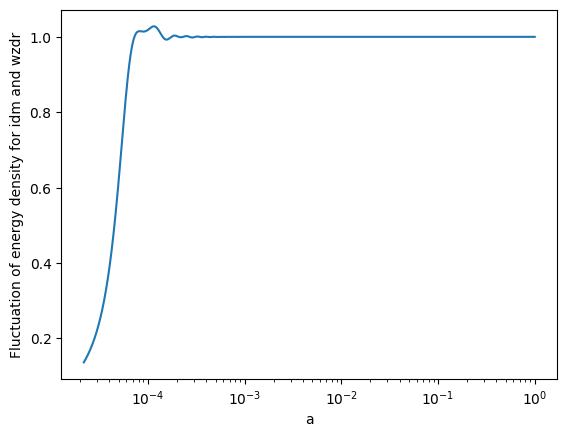

In [6]:
plt.plot(a_tau,delta_list[3])
plt.xscale('log')
plt.xlabel('a')
plt.ylabel('Fluctuation of energy density for idm and wzdr')

Text(0, 0.5, 'Fluctuation of energy density for idm and wzdr')

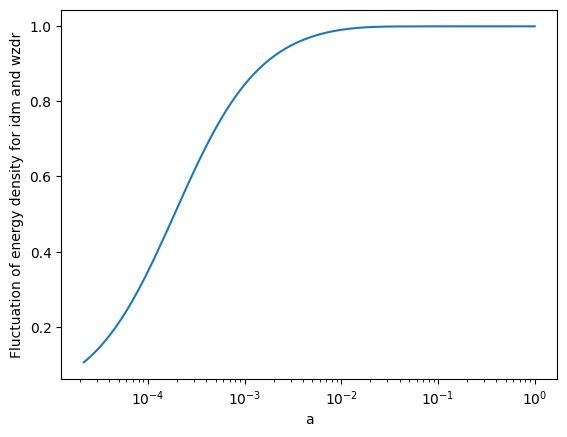

In [7]:
plt.plot(a_tau,delta_list[1])
plt.xscale('log')
plt.xlabel('a')
plt.ylabel('Fluctuation of energy density for idm and wzdr')

Text(0, 0.5, 'Fluctuation of energy density for idm and wzdr')

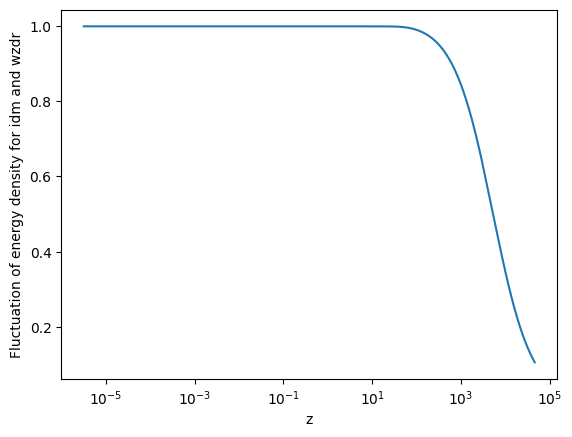

In [9]:
z_list = []
for i in a_tau:
    z = (1./i)-1
    z_list.append(z)
plt.plot(z_list,delta_list[1])
plt.xscale('log')
plt.xlabel('z')
plt.ylabel('Fluctuation of energy density for idm and wzdr')